# Network creation trials

notebook focused on creating graph from our dataset. after defining the functions we'll use, we show a toy model of a couple streets, then we show the network of the entire dataset, and finally the entire dataset minus TANGENZIALI and large adjacent roads.

### Imports and function definitions

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
#retrieve the dataset
import os
import zipfile
cwd = os.getcwd()
dataname = 'dataset_vehicles'
if os.path.exists(dataname):
    vehicle_path = dataname + '/dataset_vehicles/AC_VEI_AC_VEI_SUP_SR.shp'
else:
    !wget -nv -O dataset_vehicles.zip https://github.com/RiccardoBasilone/roadnets/raw/master/dataset_vehicles.zip -nc
    zip_filename = 'dataset_vehicles.zip'
    extract_dir = './dataset_vehicles'
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

    vehicle_path = os.path.join(cwd,'dataset_vehicles/dataset_vehicles/AC_VEI_AC_VEI_SUP_SR.shp')

In [3]:
gdf = gpd.read_file(vehicle_path)

In [4]:
#initial cleaning 

gdf.drop(['AC_VEI_FON', 
          #'AC_VEI_LIV', 'AC_VEI_SED', 
          'CLASSREF'],axis = 1, inplace = True)
gdf.rename(columns={'SUBREGID':'ID', 'NOME': 'NAME', 'AC_VEI_ZON': 'TYPE'}, inplace = True)

# portions of road (e.g not intersections or parking lots) start with 01 in TYPE
# intersections, squares, and roundabouts start with 02 in TYPE

#gdf = gdf[~gdf['NAME'].str.contains('TANGENZIALE', regex = False)] #removing tangenziali
pattern1 = ('01','02')
gdf = gdf.loc[gdf.TYPE.str.startswith(pattern1)]

In [5]:
#we use openstreetmap crs, because it's a common projected (not geographic) CRS --> useful for calculating distances
OSM_crs = 3857
gdf.to_crs(epsg=OSM_crs, inplace = True)

In [6]:
#divides gdf into intersections and roads

def ints_and_roads(gdf):

    pattern2 = ('01')
    pattern3 = ('02') 
    pattern4 = ('0102') 
    roads = gdf.loc[(gdf.TYPE.str.startswith(pattern2)) #& ~ (gdf.TYPE.str.startswith(pattern4))
    ]
    ints = gdf.loc[(gdf.TYPE.str.startswith(pattern3)) #| (gdf.TYPE.str.startswith(pattern4))
    ]
    return ints, roads

In [7]:
#function creates geodataframe with all streets of gdf within distance dist (in meters) of street.
#street is a geodataframe, dist is a positive number, and gdf is the geodataframe dataset.

def within_dist(street, dist, gdf):

    temp = street.copy()
    temp.geometry = temp.geometry.buffer(dist)
    temp = temp.filter(['geometry']) #so sjoin doesn't give suffixes and i don't have to rename later
    gdf_distanced = gdf.sjoin(temp, how='inner', predicate='intersects')
    gdf_distanced = gdf_distanced.dropna()
    gdf_distanced = gdf_distanced[~gdf_distanced.index.duplicated(keep='first')] #removes streets that are in more than one polygon's buffer
    gdf_distanced = gdf_distanced.iloc[:,:-1] #drops index_R column
    return gdf_distanced

In [8]:
#we define a variation of the within_dist function. This one keeps duplicate entries because they are useful for creating the graph later on.

def within_dist_dupes(street, dist, gdf):

    temp = street.copy()
    temp.geometry = temp.geometry.buffer(dist)
    temp = temp.filter(['geometry']) #so sjoin doesn't give suffixes and i don't have to rename later
    gdf_distanced = gdf.sjoin(temp, how='inner', predicate='intersects')
    #gdf_distanced = gdf_distanced.dropna()
    return gdf_distanced

In [9]:
#calculates width of all entries in gdf, and adds them to a width column. Assumes rectangular equivalent shape for polygons

def calc_widths(gdf):
    gdf['temp'] = 1 # create column of ones
    gdf['SemiPeri'] = -gdf.length/2 # i need it negative for the equation
    gdf['Area'] = gdf.area
    def calculate_roots(row):
        coefficients = row[['temp', 'SemiPeri', 'Area']].values
        roots = np.roots(coefficients).real
        return roots

    #gdf['roots'] = gdf.apply(calculate_roots, axis=1)
    gdf['roots'] = gdf[['temp', 'SemiPeri', 'Area']].apply(calculate_roots, axis=1)
    gdf[['length', 'width']] = pd.DataFrame(gdf['roots'].tolist(), index=gdf.index)
    gdf = gdf.drop([ 'Area', 'temp', 'SemiPeri', 'roots'], axis = 1)
    return gdf

In [10]:
#takes gdf, finds adjacent roads and dissolves them into one
def dissolver(gdf):

        gdf.reset_index(inplace = True, drop = True)
    #divide intersections and roads
        ints, roads = ints_and_roads(gdf)
    
    #gives adjacency for roads of gdf
        adj = within_dist_dupes(roads,0.1,roads)
        adj_ints = within_dist_dupes(ints,0.1,ints)
    
    #remove self connections and islands (speeds up execution significantly)
    #NB this works because index and index_right are the indices of two connected roads/ints
        adj = adj[adj.index_right != adj.index]
        adj_ints = adj_ints[adj_ints.index_right != adj_ints.index]

    #create network to find connected components
        edge_list = pd.DataFrame(zip(adj.index, adj.index_right), columns = ['from', 'to'])
        G = nx.from_pandas_edgelist(edge_list, 'from', 'to' , create_using=nx.MultiGraph())
        edge_list_ints = pd.DataFrame(zip(adj_ints.index, adj_ints.index_right), columns = ['from', 'to'])
        G_ints = nx.from_pandas_edgelist(edge_list_ints, 'from', 'to' , create_using=nx.MultiGraph())

    #store connected components in dictionary
        mylist = sorted(nx.connected_components(G), key = len, reverse = True)
        mydict = {f'component_{i}': val for i, val in enumerate(mylist)}
        mylist_ints = sorted(nx.connected_components(G_ints), key = len, reverse = True)
        mydict_ints = {f'component_{-i-1}': val for i, val in enumerate(mylist_ints)} #give negative keys to int chains, to distinguish from road chains
    
    #if index of the road/int is in dict, tag it with the key of the dict. if not, tag it with itself
        def get_key_or_index(idx, mydict):
            for key, vals in mydict.items():
                if idx in vals:
                    return key
            tag = 'self_' + str(idx)
            return tag
    #this is to suppress setting with copy warning
        pd.options.mode.chained_assignment = None
    #apply tagging function to all rows of the gdf
        roads['component'] = roads.index.map(lambda idx: get_key_or_index(idx, mydict))
        ints['component'] = ints.index.map(lambda idx: get_key_or_index(idx, mydict_ints))
        roads = roads.dissolve(by = 'component', as_index = False)
        ints = ints.dissolve(by = 'component', as_index = False)
        gdf = pd.concat([ints, roads])
        gdf.reset_index(inplace = True, drop = True)
        return gdf


In [11]:
def make_edges(gdf_tot):

    #prep
    #takes dataset with roads and intersections, creates edgelist of nodes with weights of edges
    ints, roads = ints_and_roads(gdf_tot)
    #we need indices from 0 --> reset
    ints.reset_index(inplace = True, drop = True)
    roads.reset_index(inplace = True, drop = True)


    #body
    stubs = within_dist_dupes(ints, 1, roads) #all stubs, i.e all roads connected to all nodes
    grouped = stubs.groupby('index_right') #one dataframe for each node
    edges = {} # will contain intersections of each node 
    edge_list = pd.DataFrame(columns = ['from','to','weight'])
    for node, group in grouped:
        stubs = stubs[stubs['index_right'] != node] #removing "self" from gdf that we will merge onto, to avoid self connections. also removes redundancies  
        edges[node] = pd.merge(group,stubs, on = 'ID', how = 'inner')
        edge_list_temp = pd.DataFrame({'from': edges[node].index_right_x, 'to': edges[node].index_right_y, 'weight': edges[node].width_x})
        edge_list = pd.concat([edge_list if not edge_list.empty 
                               else None,edge_list_temp])
    
    
    #exceptions    
    #adds self-edges to nodes that don't appear in to or from
    conc = pd.concat([edge_list['from'], edge_list['to']])
    all = set(range(0, len(ints))) #all possible nodes
    there = set(conc.unique()) #the nodes we actually have
    not_there = sorted(list(all-there)) #missing nodes (irregardless of why they're missing for the moment)
    df_self = pd.DataFrame({'from': not_there, 'to': not_there, 'weight': [1] * len(not_there)})
    edge_list = pd.concat([edge_list, df_self])
    return edge_list
    


In [12]:
def calc_pos(gdf, G):
    #takes dataset and network, calculates node positions and stores them in dict
    
    ints, _ = ints_and_roads(gdf)
    cent = ints.centroid
    coordinates = np.column_stack((cent.geometry.x, cent.geometry.y))
    positions = dict(zip(sorted(G.nodes), coordinates))
    return positions

In [13]:
def plot_clusters(positions, G):
    #takes network, plots clusters by color and edge width by color
    
    Gcc = sorted(nx.connected_components(G), key = len, reverse = True)
    
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.set_title("Road graph.\n Nodes are colored by cluster, and edges are colored by width")
    ax.axis("off")
    colorlist = [ 'r', 'g', 'b', 'y', 'orange']
    #plot each component one at a time
    
    for i in range(0, len(Gcc)):
        nx.draw_networkx_nodes(G, positions, nodelist = list(Gcc[i]), 
                               node_color = colorlist[i%5], ax=ax, 
                               node_size=0.8, alpha = 0.3)
    #now draw all edges using color map
    edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
    nx.draw_networkx_edges(G, positions, edge_color = weights, 
                           edge_cmap = plt.cm.inferno, 
                           edge_vmin = min(weights), edge_vmax = max(weights), width =0.3,
                           node_size = 0.9,
                           ax = ax)   
    #labels = nx.draw_networkx_labels(G, pos=positions, font_size = 6)
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    plt.savefig('graph clusters.png')
    plt.show()

## Creating the Networks

Our networks will have intersections as nodes and roads as edges. an edge will be placed between two nodes when there is a road connecting them.  
Our dataset sometimes has consecutive roads counted as distinct ones; we must join consecutive roads together so that we can properly place edges between nodes.  
The tool to do this is geopandas Dissolve function.  
Using it blindly gives us ugly, overconnected graphs, for 3 main reasons:  
1) some polygons are considered adjacent when they shouldn't be, just because they have one pair of corners that touch
2) some polygons are considered adjacent when they shouldn't be, just because they're one on top of the other (e.g tunnels/bridges)
3) Tangenziali give rise to overconnections because they're hard to deal with even after solving 1) and 2) as best we can

We get around 1) by applying a buffer back and forth, to round out corners, and we solve 2) by applying dissolve in two distinct "steps": once on all roads at the same level (same "AC_VEI_SED") and then to all roads at same AC_VEI_LIV. this gives a properly behaving dataset.  
Finally, we will show that removing tangenziali from the dataset does not significantly alter the structure of the network, but it does help "clean up"

### Toy model: streets near tangenziali

First we show how dissolve joins adjacent roads.  Then we demonstrate how dissolving with tangenziali leads to large edges that are hard to deal with.  

In [14]:
gdf = calc_widths(gdf)

In [15]:
toy = gdf.loc[gdf.NAME == 'VIA GAUDENZIO FANTOLI']

In [16]:
toy_d  = dissolver(toy)

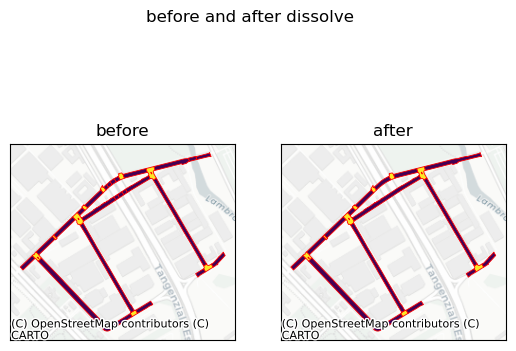

In [17]:
fig, ax = plt.subplots(1,2)
fig.suptitle('before and after dissolve')
ax[0].set_title('before')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_title('after')
ax[1].set_xticks([])
ax[1].set_yticks([])

toy.plot(column = 'TYPE', cmap = 'viridis', edgecolor = 'r', linewidth = 0.6, ax = ax[0])
toy_d.plot(column = 'TYPE', cmap = 'viridis', edgecolor = 'r', linewidth = 0.6, ax = ax[1])
cx.add_basemap(ax[0], crs=toy.crs, zoom = 15, source=cx.providers.CartoDB.Positron)
cx.add_basemap(ax[1], crs=toy.crs, zoom = 15, source=cx.providers.CartoDB.Positron)
plt.show()

Consecutive roads were successfully dissolved into single roads.  Now the intersections (in yellow) will be properly detected as connected by edges.

Now let's add tangenziali to our toy model

In [18]:
toy = within_dist(toy,100,gdf) #takes all streets within 100 m of toy
toy_d  = dissolver(toy)

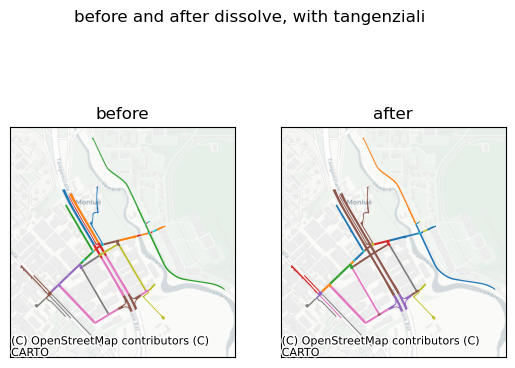

In [19]:
fig, ax = plt.subplots(1,2)
fig.suptitle('before and after dissolve, with tangenziali')
ax[0].set_title('before')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].set_title('after')
ax[1].set_xticks([])
ax[1].set_yticks([])

toy.plot(column = 'ID', ax = ax[0])
toy_d.plot(column = 'ID', ax = ax[1])
cx.add_basemap(ax[0], crs=toy.crs, zoom = 15, source=cx.providers.CartoDB.Positron)
cx.add_basemap(ax[1], crs=toy.crs, zoom = 15, source=cx.providers.CartoDB.Positron)
plt.show()

Each individual street or intersection has its color. We see that in the before image there are many streets, whereas in the after image The tangenziale has combined with some other streets to become one large brown street.  This is a problem because it means that all the nodes that the tangenziale touches will be connected by this very large edge.  

We can see a more in depth image using the gdf.explore() command.  Remember, TYPE that starts with 01 counts as a road, and with 02 counts as an intersection.  
By looking around you can see that many intersections are connected by one large brown road.  
For example, the intersection of VIALE DELL'AVIAZIONE (in cyan) connects to the same road polygon four times... 

In [20]:
m = toy_d.explore(column = 'ID') #column = 'TYPE' to see color coding of intersections/roads instead
m

It's clear to see that the tangenziale has engulfed a piece of Via Gaudenzio Fantoli into it (NB THESE STREETS ARE NOT EVEN AT THE SAME HEIGHT, SO THIS IS ANOTHER CRITICALITY OF THIS METHOD) and via Monlue.

### Entire dataset with tangenziali

now let's look at the actual graph of the road network

In [21]:
gdf = calc_widths(gdf)

In [22]:
gdf10 = gdf.copy()
gdf10.geometry = gdf10.geometry.buffer(0.3, join_style=1).buffer(-0.6, join_style=1).buffer(0.3, join_style = 1) #dulls corners
gdf10 = gdf10[~gdf10.is_empty] #removes possible empty geometries created in dulling

gdf10['SED_cpy'] = gdf10.AC_VEI_SED
gdf10['LIV_cpy'] = gdf10.AC_VEI_LIV #copies to dissolve columns

gdf10 = gdf10.groupby('SED_cpy', as_index = False, group_keys = False).apply(dissolver, include_groups = False)
gdf10 = gdf10.groupby('LIV_cpy', as_index = False, group_keys = False).apply(dissolver, include_groups = False)
gdf10 = calc_widths(gdf10)
gdf10.reset_index(inplace = True, drop = True)

In [23]:
edges_10 = make_edges(gdf10)

G10 = nx.from_pandas_edgelist(edges_10, 'from', 'to', edge_attr=["weight"] , create_using=nx.MultiGraph())
Gcc = sorted(nx.connected_components(G10), key = len, reverse = True)

print("Number of components: ",len(Gcc),
      "\n largest: ",  len(Gcc[0]),
      "\n second largest: " , len(Gcc[1]),
      "\n third largest: " ,len(Gcc[2])
     )

Number of components:  27 
 largest:  7551 
 second largest:  15 
 third largest:  9


A perfect fully connected network would have just one giant component. We have a few exceptions in our dataset, but at least we see that the second largest component only has 15 nodes.  



### Graph plot:

We plot the graph network below. NB isolated nodes have been given a self loop to make them more visible in the plot. The loop has no geographical meaning.

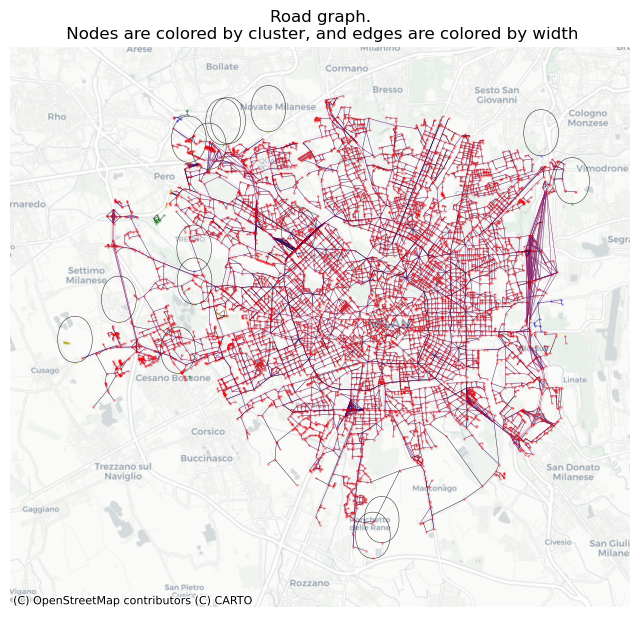

In [24]:
positions = calc_pos(gdf10, G10)
plot_clusters(positions, G10)

The large purplish clusters are all the regions where tangenziali are present.  The number of the nodes in the regions is correct, but all of them seem to be connected by these extremely long and identical edges.

## Entire dataset without tangenziali

Let's see what the network looks like without tangenziali.

In [25]:
gdf = gdf.loc[~gdf['NAME'].str.contains('TANGENZIALE', regex = False)] #removing tangenziali

In [27]:
gdf11 = gdf.copy()
gdf11.geometry = gdf11.geometry.buffer(0.3, join_style=1).buffer(-0.6, join_style=1).buffer(0.3, join_style = 1) #dulls corners
gdf11 = gdf11[~gdf11.is_empty] #removes possible empty geometries created in dulling

gdf11['SED_cpy'] = gdf11.AC_VEI_SED
gdf11['LIV_cpy'] = gdf11.AC_VEI_LIV #copies to dissolve columns

gdf11 = gdf11.groupby('SED_cpy', as_index = False, group_keys = False).apply(dissolver, include_groups = False)
gdf11 = gdf11.groupby('LIV_cpy', as_index = False, group_keys = False).apply(dissolver, include_groups = False)
gdf11 = calc_widths(gdf11)
gdf11.reset_index(inplace = True, drop = True)

In [28]:
edges_11 = make_edges(gdf11)

G11 = nx.from_pandas_edgelist(edges_11, 'from', 'to', edge_attr=["weight"] , create_using=nx.MultiGraph())
Gcc = sorted(nx.connected_components(G11), key = len, reverse = True)

print("Number of components: ",len(Gcc),
      "\n largest: ",  len(Gcc[0]),
      "\n second largest: " , len(Gcc[1]),
      "\n third largest: " ,len(Gcc[2])
     )

Number of components:  24 
 largest:  7416 
 second largest:  15 
 third largest:  9


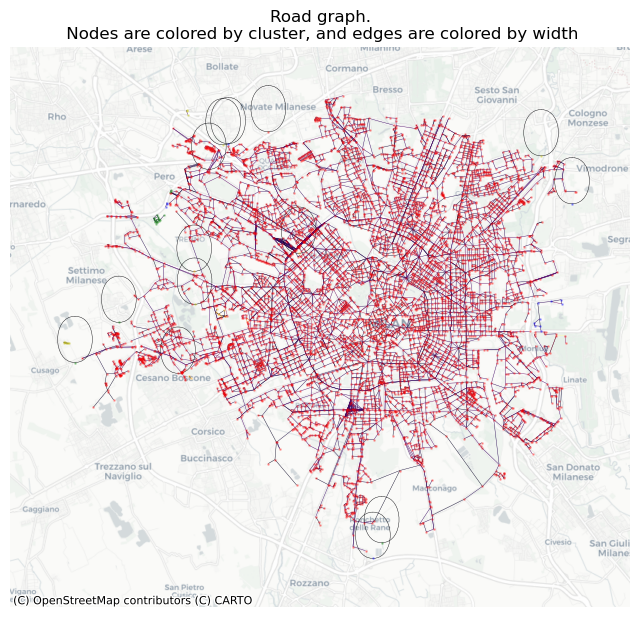

In [29]:
positions = calc_pos(gdf11, G11)
plot_clusters(positions, G11)

Most of the criticalities have disappeared! 

## Average length and width distribution of roads

Let's look at some metrics:

In [30]:
gdf11.head() #length is stored in root1 column, width in width

,component,geometry,NAME,ID,AC_VEI_LIV,AC_VEI_SED,TYPE,length,width
0,self_0,"POLYGON ((1026895.140 5691022.450, 1026895.158...",PIAZZALE LUIGI EMANUELE CORVETTO,AC_VEI_SR_10753,01,01,0204,449.112724,17.633568
1,self_1,"MULTIPOLYGON (((1023305.447 5695334.783, 10233...",PIAZZA BELGIOIOSO,AC_VEI_SR_10802,01,01,0204,453.444118,10.380277
2,self_2,"POLYGON ((1020906.369 5690628.317, 1020906.343...",PIAZZA GIAN ANTONIO MAGGI,AC_VEI_SR_29939,01,01,0204,65.531918,10.062970
3,self_3,"POLYGON ((1020942.174 5690721.977, 1020942.150...",PIAZZA GIAN ANTONIO MAGGI,AC_VEI_SR_29940,01,01,0204,102.187295,13.054709
4,self_4,"POLYGON ((1021305.357 5690529.122, 1021305.330...",PIAZZA FRANCESCO CARRARA,AC_VEI_SR_30012,01,01,0204,922.314581,14.494799


In [31]:
print('length comparison \n',
      'with tangenziali: ', gdf10.length.mean(),
      '+- ', gdf10.length.std(),
      '\n \t median: ', gdf10.length.median(),
      '\n without tangenziali: ' , gdf11.length.mean(),
      '+- ', gdf11.length.std(),
      '\n \t median: ',gdf11.length.median())

length comparison 
 with tangenziali:  288.84504456508824 +-  422.4616046191317 
 	 median:  182.45807416308426 
 without tangenziali:  279.2297167532033 +-  356.4385240814002 
 	 median:  180.96728074914768


NB the average doesn't change much but std decreases significantly

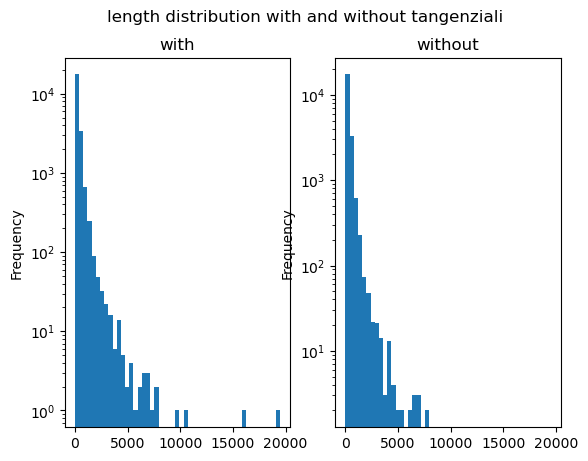

In [32]:
fig, ax = plt.subplots(1,2)
fig.suptitle('length distribution with and without tangenziali')
ax[0].set_title('with')
ax[1].set_title('without')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
range = np.linspace(0,gdf10.length.max(), 50)
gdf10.length.plot(kind = 'hist', bins = range,ax = ax[0],)
gdf11.length.plot(kind = 'hist', bins = range, ax = ax[1],)
plt.show()

We can see that removing tangenziali loses a large portion of the longest streets.

In [33]:
print('width comparison \n',
      'with tangenziali: ', gdf10.width.mean(),
      '+- ', gdf10.width.std(),
      '\n \t median: ', gdf10.width.median(),
      '\n without tangenziali: ' , gdf11.width.mean(),
      '+- ', gdf11.width.std(),
      '\n \t median: ',gdf11.width.median())

width comparison 
 with tangenziali:  12.664681563049866 +-  4.673242972136735 
 	 median:  11.726702036591545 
 without tangenziali:  12.586958180791603 +-  4.584900458854926 
 	 median:  11.688433106293747


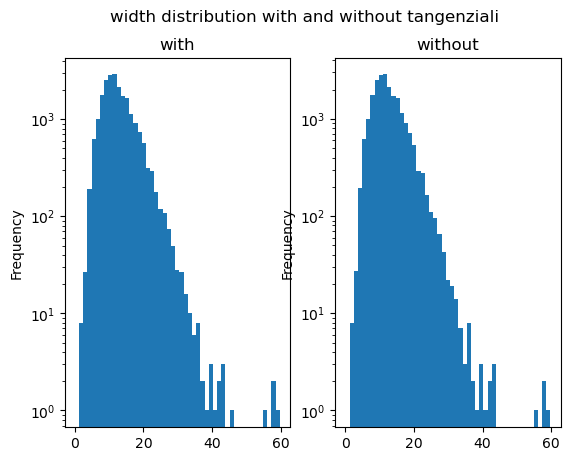

In [35]:
fig, ax = plt.subplots(1,2)
fig.suptitle('width distribution with and without tangenziali')
ax[0].set_title('with')
ax[1].set_title('without')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
range = np.linspace(0,gdf10.width.max(), 50)
gdf10.width.plot(kind = 'hist', bins = range,ax = ax[0],)
gdf11.width.plot(kind = 'hist', bins = range, ax = ax[1],)
plt.show()

Width is practically identical with and without. This makes sense, since tangenziali aren't wide enough to skew the metric.  

All this suggests that removing Tangenziali from the dataset could significantly clean up the dataset while preserving the structure and metrics of the network.  
Let me know what you think.

## Percolation and keeping track of removed lengths
To do